# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

## Importando as Bibliotecas

In [4]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

## Criando o Dataframe

In [5]:
meses = { 'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set':9, 'out':10, 'nov':11, 'dez':12 }

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

# Percorrendo os arquivos da base de dados e salvando no data frame base_airbnb
for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses [nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name)

    # adicionando coluna do ano e do mês
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

# display(base_airbnb)

#abril2018_df = pd.read_csv(r'dataset\abril2018.csv')
#display(abril2018_df)

C:\Users\55169\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\55169\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\55169\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Idenficiação das Variáveis

### Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
1. IDs, Links e informações não relevantes ao modelo.
2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mes)
3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
4. Colunas em que todos ou quase todos os valores são iguais

- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa


In [6]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [7]:
colunas = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb.columns)

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'ano', 'mes'],
      dtype='object')

## Tratamento de valores Missing

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise.
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [8]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [9]:
# Percorrendo as colunas do nosso dataframe retirando as colunas que continham muitos valores vazios

for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

# Retirando os valores vazios das colunas 'bathrooms', 'bedrooms' e 'beds'              
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())


(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


## Tratamento dos Tipos de Dados em cada coluna
- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna

In [10]:
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [11]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extrapeople
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

# Verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


## Análise Exploratória e Tratamento de Outliers

- Vamos percorrer colunas para entender sobre a estatística dos dados que usaremos no modelo;
- Outliers -> Valores que estão abaixo do limite inferior (Q1 - 1.5 x Amplitude) e acima do limite superior (Q3 + 1.5 x Amplitude)
- Correlação -> Qual a relação entre as duas colunas? (positiva/negativa)

1. Em primeiro lugar analisamos a coluna de preço (resultado final desejado) e de extra_people (valor monetário), esses são valores numéricos contínuos
2. Depois analisamos as colunas de valores numéricos discretos/inteiros (accomodates, bedrooms, guests_included, etc.)
3. Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

<AxesSubplot:>

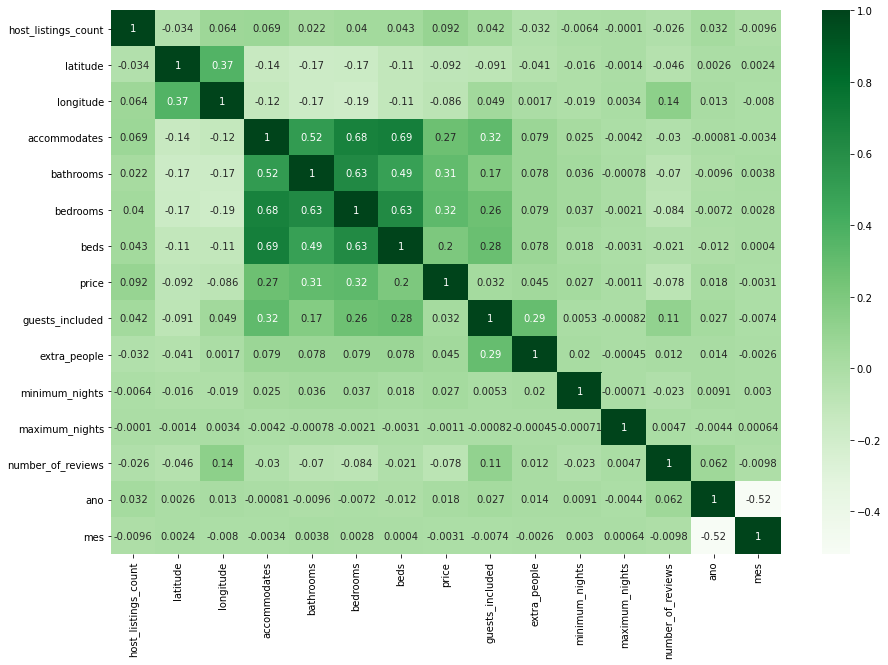

In [12]:
# Construindo um gráfico de calor para análise de correlação entre as colunas

plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

## Definição de Funções para Análise de Outliers

- limites(coluna): Q1 - 1.5 x Amplitude / Q3 + 1.5 x Amplitude </br>
Define quais são os limites onde os outliers são encontrados <br></br>

- excluir_outliers:(df, nome_coluna): exclusão dos outliers do data frame e análise de quatidade de linhas removidas </br>
Remove as linhas que são outliers



In [13]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude


def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

- Para todas as colunas analisaremos três gráficos por isso criamos uma nova função

1. Diagrama de caixa (boxplot) analisando os outliers
2. Diagrama de caixa (boxplot) com outliers retirados
3. Histograma para análise de distribuição dos dados

In [14]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)


def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))


### Price

C:\Users\55169\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(897709, 23)


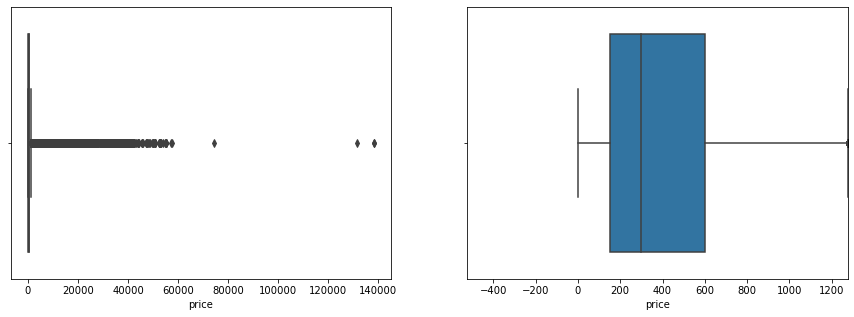

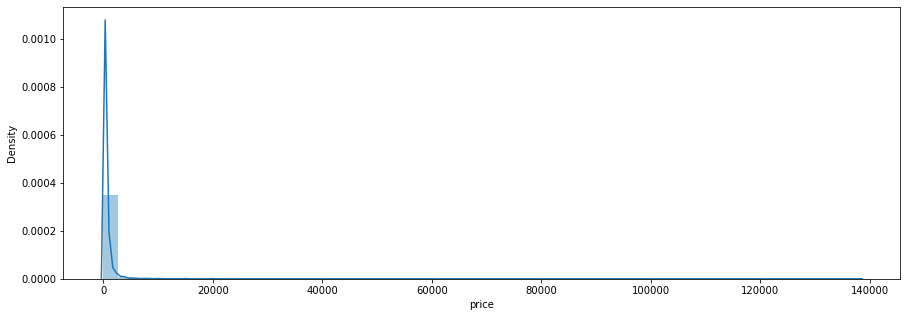

In [15]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])
print(base_airbnb.shape)

Como estamos construindo um modelo para imóveis comuns, acredito que os valore acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses Outliers


In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


C:\Users\55169\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 23)


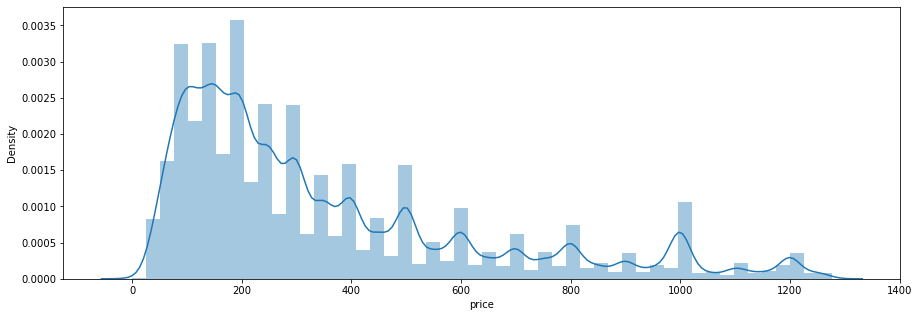

In [17]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### Extra People

C:\Users\55169\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


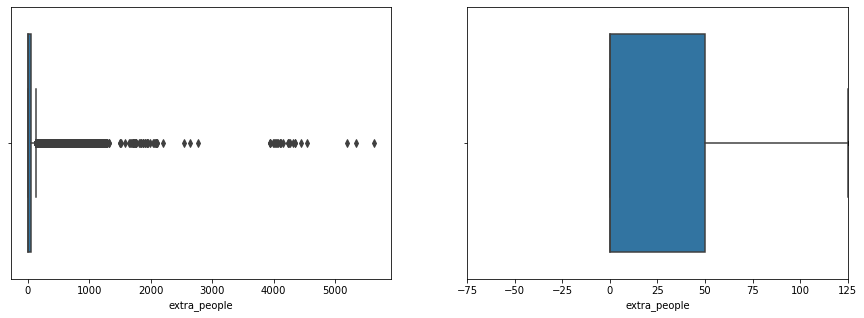

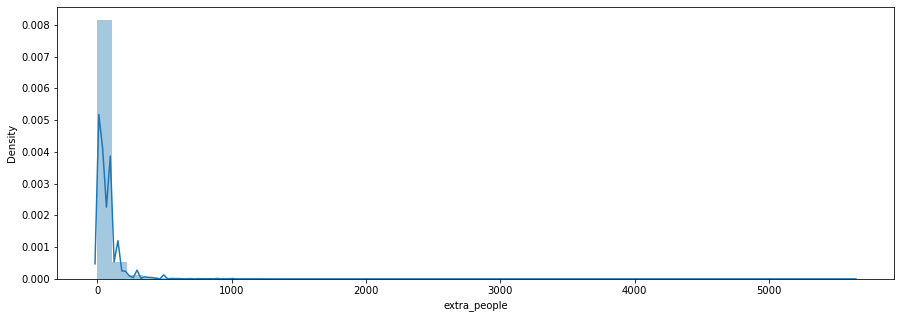

In [18]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} Linhas Removidas'.format(linhas_removidas))

59194 Linhas Removidas


C:\Users\55169\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(751233, 23)


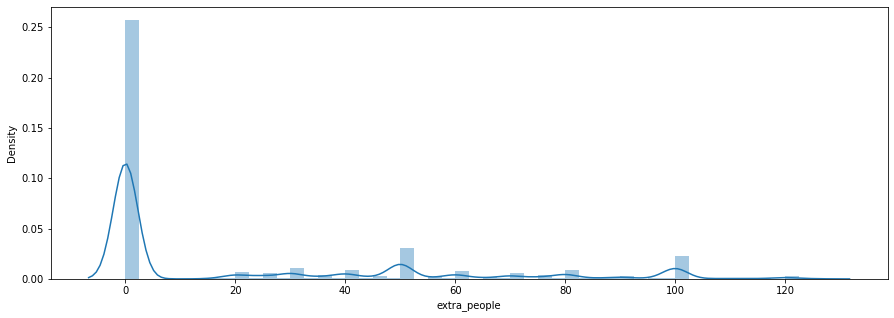

In [20]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_listings_count

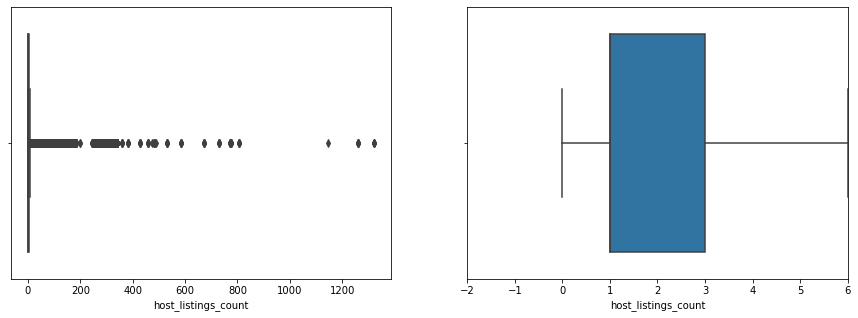

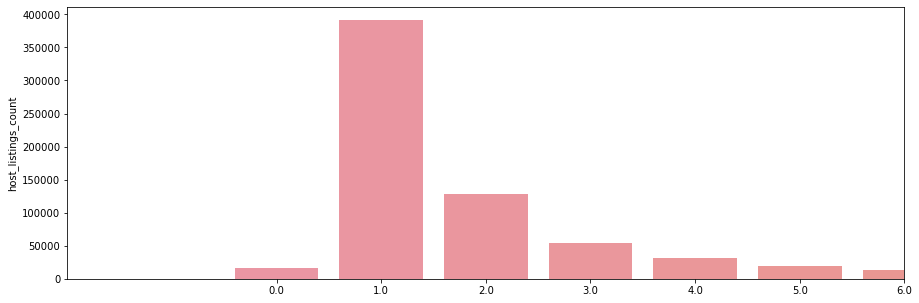

In [21]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto os hosts com mais de 6 imóveis no airbnb não são público alto do objetivo do projeto (imagino que sejam imobiliárias ou profissionais que gerenciam imóveis no airbnb)

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} Linhas Removidas'.format(linhas_removidas))

97723 Linhas Removidas


### accommodates

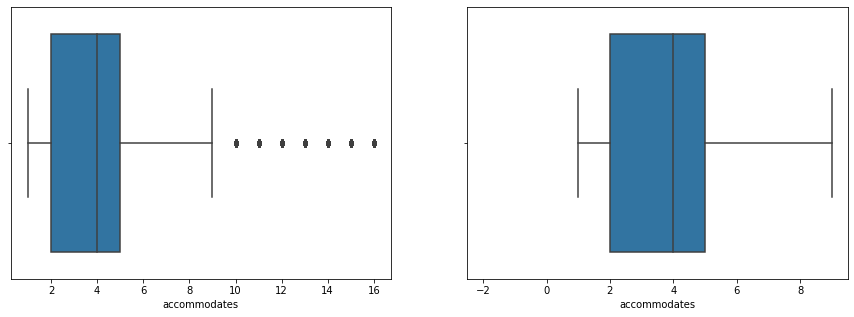

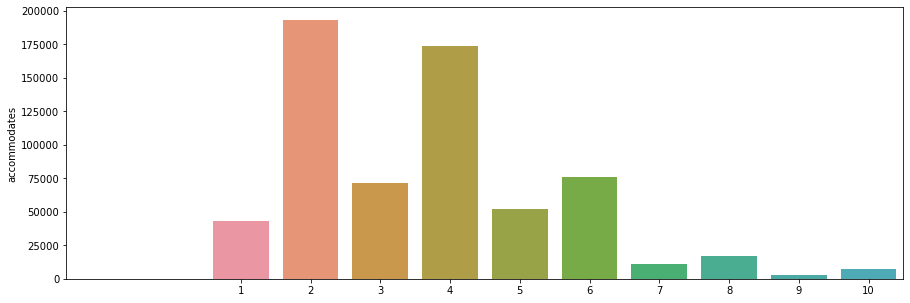

In [23]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} Linhas Removidas'.format(linhas_removidas))

13146 Linhas Removidas


### bathrooms

<AxesSubplot:ylabel='bathrooms'>

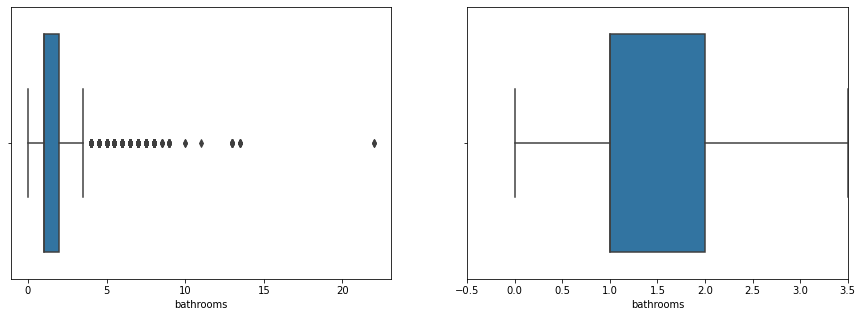

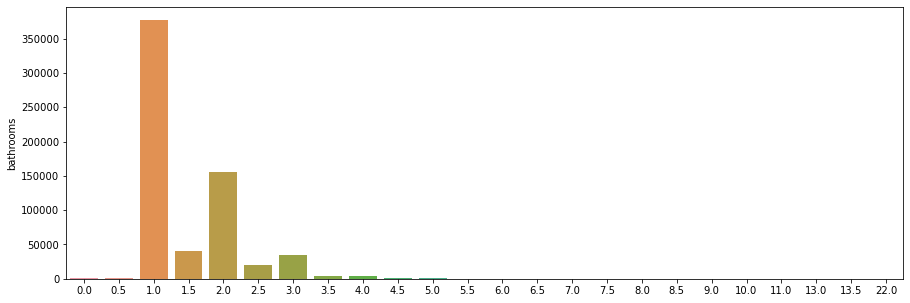

In [25]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} Linhas Removidas'.format(linhas_removidas))

6894 Linhas Removidas


### bedrooms

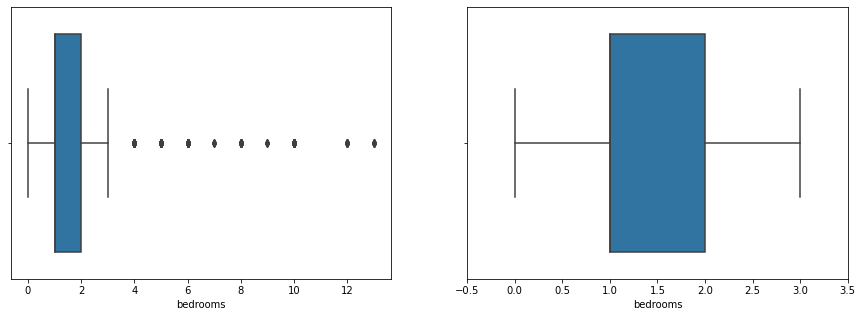

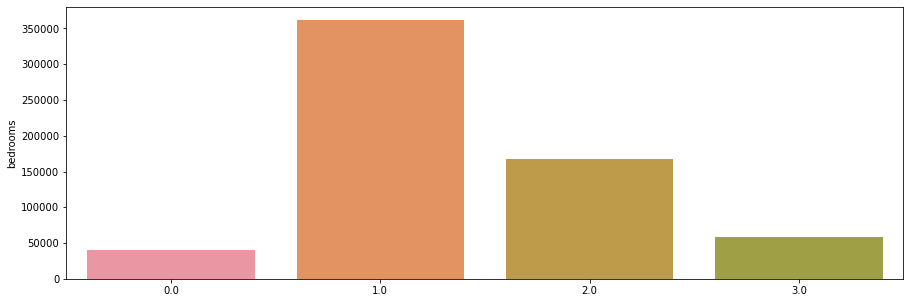

In [27]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [28]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} Linhas Removidas'.format(linhas_removidas))

5482 Linhas Removidas


### beds

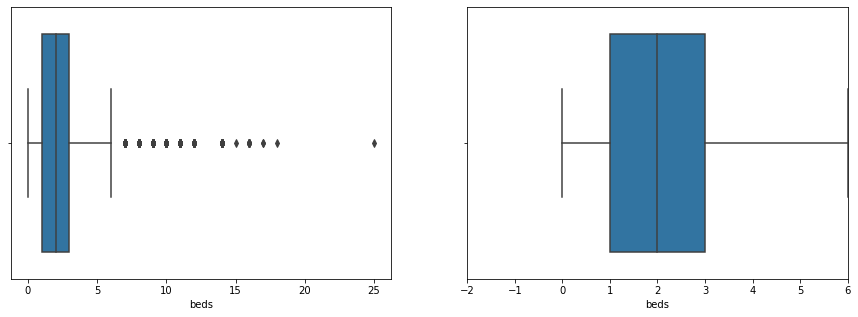

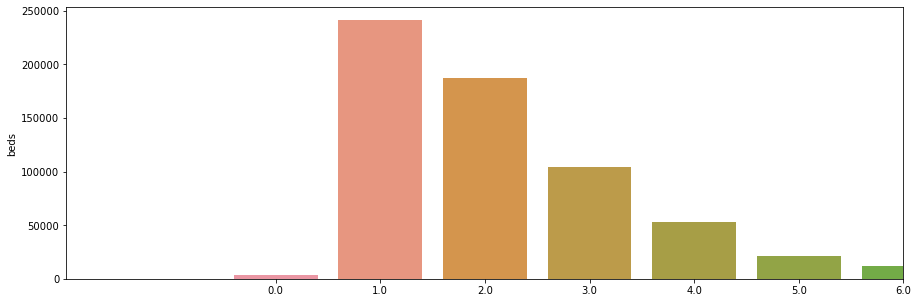

In [29]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [30]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} Linhas Removidas'.format(linhas_removidas))

5622 Linhas Removidas


### guests_included (pessoas incluídas no pacote)

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

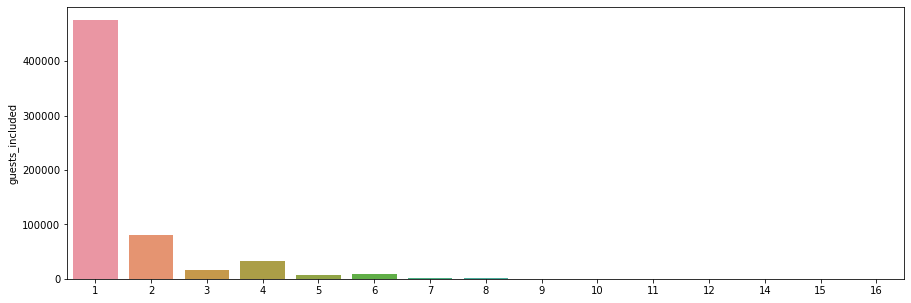

In [31]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])

print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

 Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbmn como 1 guests_included. Isso pode enviesar nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [32]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

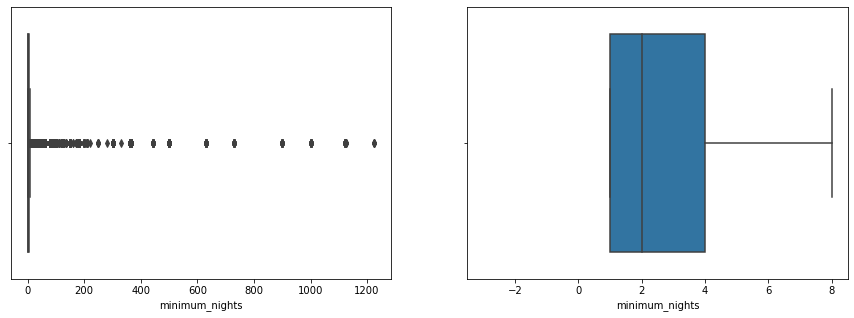

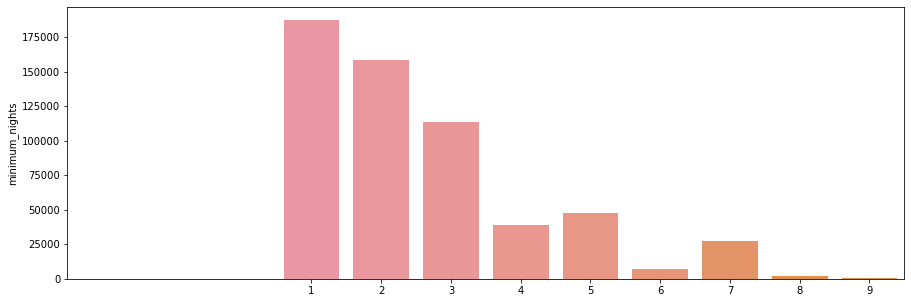

In [33]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [34]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} Linhas Removidas'.format(linhas_removidas))

40383 Linhas Removidas


### maximum_nights

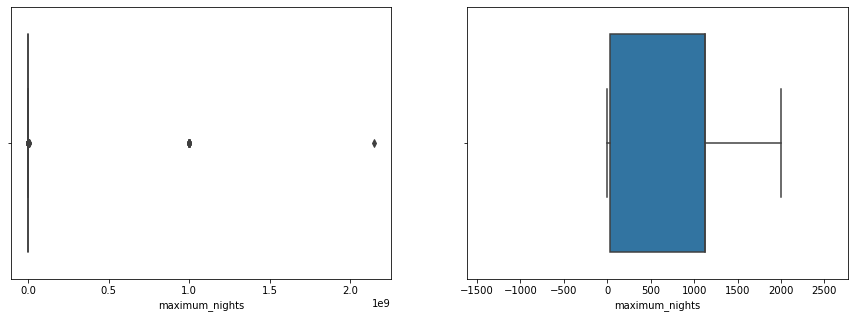

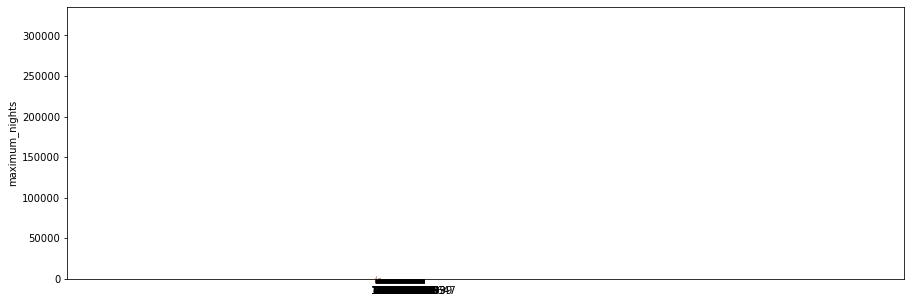

In [35]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [36]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

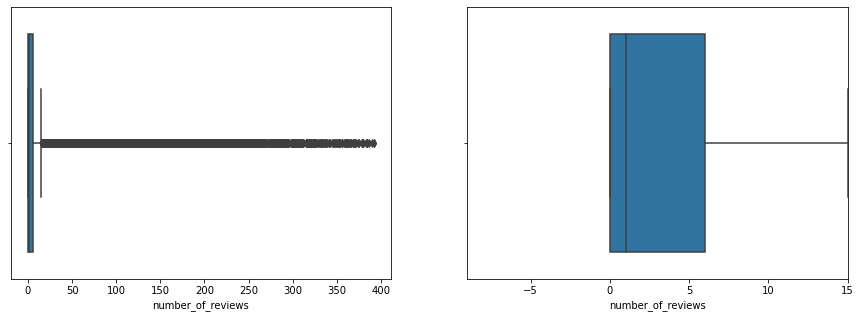

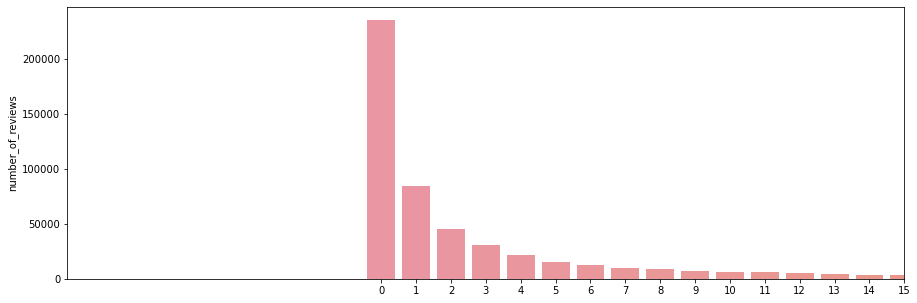

In [37]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [38]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

## Tratamento de Colunas de Valores de Texto

- Propriedades pulverizadas, por isso vamos pegar os valores que são pequenos e agrupar
- "sns.countplot('coluna', data)" usado para gerar gráfico de distribuição de valores da coluna 'property_type'
- "tick_params(axis, rotation)" para editar a legenda

### property_type

- Vamos agrupar os valores de menor representação em um tipo chamado "Other" (Outros)

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\Users\55169\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


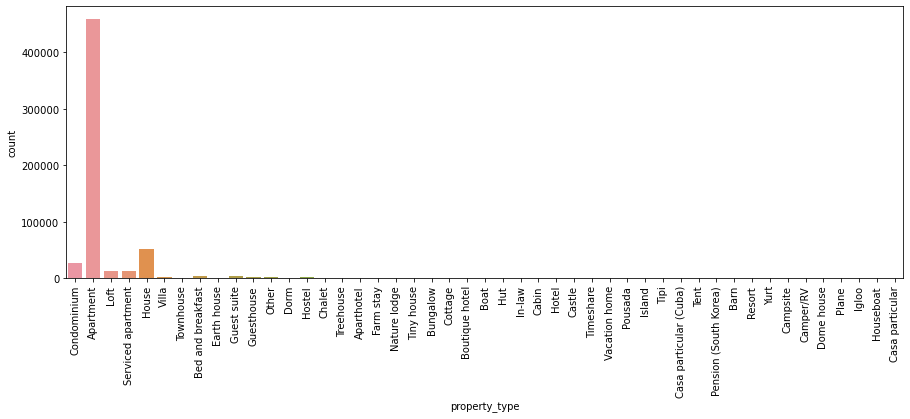

In [39]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [40]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


### amenities
- Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como parâmetro para o nosso modelo
- vamos interpretar a coluna não por quais comodidades mas sim quantas comodidades, sendo assim incluindo no modelo a interpretação se anúncios mais detalhados são mais caros

In [41]:
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[0].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [42]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

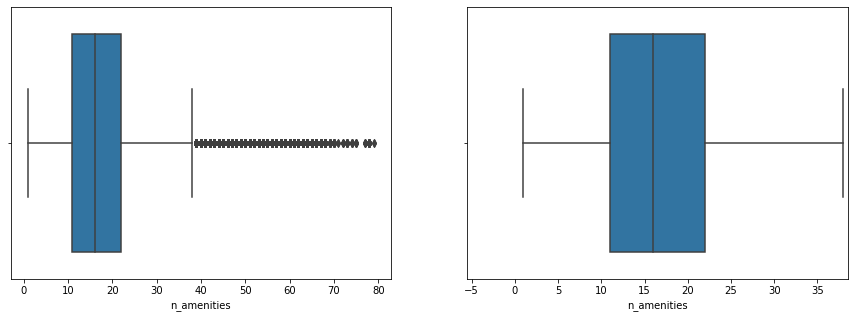

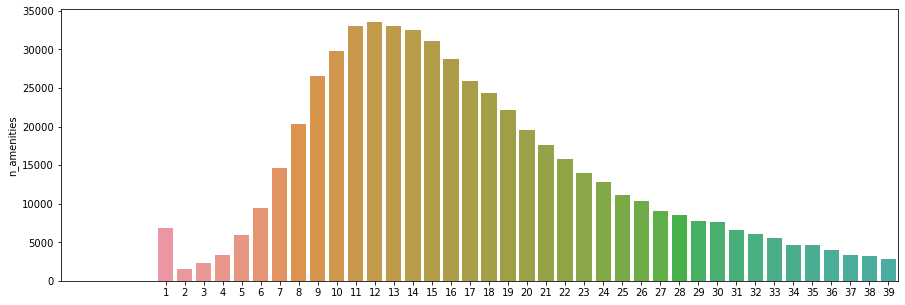

In [43]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [44]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} Linhas Removidas'.format(linhas_removidas))

24343 Linhas Removidas


### Visualização de Mapa das Propriedades

In [45]:
# 1 - tamanho da amostra
amostra = base_airbnb.sample(n=50000)

# 2 - definindo o centro do mapa
centro_mapa = {'lat': amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

# 3 - renderizando o mapa
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')

mapa.show()

property_type                object
room_type                    object
bed_type                     object
amenities                    object
cancellation_policy          object


## Encoding

- Ajustando as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies


In [46]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0
print(base_airbnb.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes', 'n_amenities'],
      dtype='object')


In [47]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,0,0,0,1,0,0,1,0,0,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,0,0,0,1,0,0,1,0,0,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,0,0,0,1,0,0,1,0,0,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,0,0,0,1,0,0,1,0,0,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,0,0,0,1,0,0,1,0,0,0


## Modelo de Previsão

### Métricas de Avaliação

- Utilizaremos duas métricas para avaliação do Modelo - R² e RSME

In [48]:
# Função para avaliação do modelo: Comparando valores de teste com de previsão utilizando duas métricas de avaliação (r² e RSME)
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. ExtraTree

In [49]:
# Criando uma instância de cada modelo escolhido
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separando os dados em treino e teste + Treino do Modelo

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    # Treino dos modelos
    modelo.fit(X_train, y_train)
    # Teste dos modelos
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.26%
RSME:43.90
Modelo LinearRegression:
R²:32.73%
RSME:217.49
Modelo ExtraTrees:
R²:97.49%
RSME:42.02


### Análise do Melhor Modelo

In [51]:
for nome_modelo, modelo in modelos.items():
    # Teste dos modelos
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.26%
RSME:43.90
Modelo LinearRegression:
R²:32.73%
RSME:217.49
Modelo ExtraTrees:
R²:97.49%
RSME:42.02


### Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

Esse foi o modelo com o maior valor de R² e ao mesmo tempo o menor valor de RSME. </br>
Como não tivemos uma grande diferença de velocidade de treino e previsão desse modelo com o modelo de Random Forest (que teve resultados próximos de R² e RSME) vamos escolher o Modelo ExtraTrees

O Modelo de regressão linear não obteve um resultado stisfatório, com valores de R² e RSME e muito piores do que os outros 2 modelos.


Resultado das métricas de avaliação no Modelo vencedor: <br>
- Modelo ExtraTrees: <br>
- R²: 97.49% <br>
- RSME: 42.02 

### Ajustes e Melhorias no Melhor Modelo

- Vamos plotar um gráfico para análise e comparação da importância das features dentro do nosso modelo, se necessário vamos retirar as que não sejam necessárias

,0
bedrooms,0.117300
latitude,0.103501
longitude,0.100721
n_amenities,0.089206
extra_people,0.087533
accommodates,0.074239
bathrooms,0.070944
minimum_nights,0.065243
room_type_Entire home/apt,0.058103
beds,0.053041


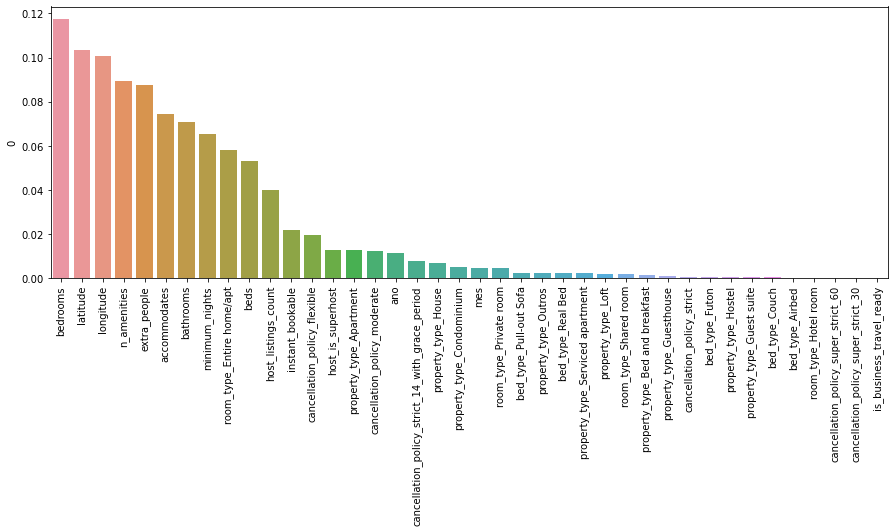

In [53]:
# print(modelo_et.feature_importances_)
# print(X_train.columns)

importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)


### Ajustes Finais do Modelo

- is_business_travel_ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples vamos excluir essa feature e testar o modelo sem ela

In [54]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.50%
RSME:41.92


### Retirando colunas para melhorar o modelo

In [56]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)

y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'],
      dtype='object')
Modelo ExtraTrees:
R²:97.49%
RSME:41.99


### Deploy do Projeto

- Passo 1: Criar arquivo do Modelo (joblib) <br>
- Passo 2: Escolher a forma de deploy: <br>
    - Arquivo Executável + Tkinter
    - Deploy em um Microsite (Flask)
    - Deploy apenas para uso direto (Streamlit) <br>
- Passo 3: Outro arquivo Python (Pode ser Jupyter ou PyCharm) <br>
- Passo 4: Importar streamlit e criar código <br>
- Passo 5: Atribuit ao botão o carregamento do modelo <br>
- Passo 6:  Deploy feito<br>